In [1]:
# importing the standard Python modules
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
from os import path
if not path.exists("avergra2.bmp"):  # avergra = avarage gradient
    !wget https://users.itk.ppke.hu/~horan/avergra2.bmp
if not path.exists("ExpectedOutput.npy"):
    !wget https://users.itk.ppke.hu/~horan/ExpectedOutput.npy

--2021-03-24 17:32:17--  https://users.itk.ppke.hu/~horan/avergra2.bmp
Resolving users.itk.ppke.hu (users.itk.ppke.hu)... 193.225.109.33
Connecting to users.itk.ppke.hu (users.itk.ppke.hu)|193.225.109.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5198 (5,1K) [image/x-ms-bmp]
Saving to: 'avergra2.bmp.1'

     0K .....                                                 100% 17,9M=0s

2021-03-24 17:32:17 (17,9 MB/s) - 'avergra2.bmp.1' saved [5198/5198]

--2021-03-24 17:32:18--  https://users.itk.ppke.hu/~horan/ExpectedOutput.npy
Resolving users.itk.ppke.hu (users.itk.ppke.hu)... 193.225.109.33
Connecting to users.itk.ppke.hu (users.itk.ppke.hu)|193.225.109.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16512 (16K) [text/plain]
Saving to: 'ExpectedOutput.npy.1'

     0K .......... ......                                     100% 1,55M=0,01s

2021-03-24 17:32:18 (1,55 MB/s) - 'ExpectedOutput.npy.1' saved [16512/16512]



In [3]:
def Uint8ToCell(arr):
    # this function convertrs an array from unit8, 0-255, oBlack, 255White 
    # to -1White, 1Black
    arr = (-1)*((arr.astype(np.float))/128.0-1.0)
    return arr

In [4]:
def CellToUint8(arr):
    # this function converts an array from unit8, 0-255, oBlack, 255White 
    # to -1White, 1Black
    arr = ((arr*-1)+1.0)*127.5
    arr = arr.astype(np.uint8)
    return arr

In [17]:
def CNN_sim(InitState, U, A, B, Z, IterNum, StepSize):
    InputCoupling = tf.nn.conv2d(U, B, strides=[1, 1, 1, 1], padding='SAME')
    InputCoupling = InputCoupling+Z

    alpha = 0.01
    x = InitState
    for it in range(IterNum):
        y = tf.minimum(x, 1+alpha*x)
        y = tf.maximum(y, -1-alpha*y)
        OutputCoupling = tf.nn.conv2d(y, A, strides=[1, 1, 1, 1], padding='SAME')
        x = x+StepSize*(-1*(x) + OutputCoupling + InputCoupling)
    y = tf.minimum(x, 1+alpha*x)
    out = tf.maximum(y, -1-alpha*y)
    return out

(3, 3, 1, 1)
(1, 64, 64, 1)


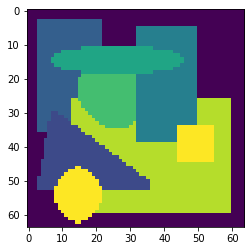

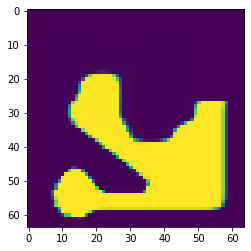

In [12]:
h = 0.1
IterNum = 50
Size = [64, 64]

img = cv2.imread('avergra2.bmp')
img = Uint8ToCell(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

bimg = np.reshape(img, [1, img.shape[0], img.shape[1], 1])

x0 = tf.constant(bimg, dtype=tf.float32)
U = tf.constant(bimg, dtype=tf.float32)

initializer = tf.initializers.glorot_uniform()
B = tf.Variable(initializer([3, 3, 1, 1]), dtype=tf.float32)
A = tf.Variable(initializer([3, 3, 1, 1]), dtype=tf.float32)
Z = tf.Variable(initializer([1]), dtype=tf.float32)
print(B.shape)

out = CNN_sim(x0, U, A, B, Z, IterNum, h)
print(out.shape)
outimg = out[0, :, :, 0]
plt.imshow(img)  # displaying the input image
plt.figure()
plt.imshow(outimg)

In [13]:
@tf.function
def compute_loss(exp_out, modelout):
    return tf.reduce_mean(tf.abs(exp_out-modelout))

In [14]:
@tf.function
def train_step(model, optimizer, exp_out, x0, U, A, B, Z, IterNum, h):
    with tf.GradientTape() as tape:
        model_out = CNN_sim(x0, U, A, B, Z, IterNum, h)
        loss = compute_loss(exp_out, model_out)

    # compute gradient
    grads = tape.gradient(loss, [A, B, Z])
    # update to weights
    optimizer.apply_gradients(zip(grads, [A, B, Z]))
    # accuracy = compute_accuracy(logits, y)
    # loss and accuracy is scalar tensor
    return loss  # accuracy

tf.Tensor(0.68263817, shape=(), dtype=float32)
tf.Tensor(0.20476857, shape=(), dtype=float32)
tf.Tensor(0.18217832, shape=(), dtype=float32)
tf.Tensor(0.10867524, shape=(), dtype=float32)
tf.Tensor(0.10535017, shape=(), dtype=float32)
tf.Tensor(0.0796494, shape=(), dtype=float32)
tf.Tensor(0.6054506, shape=(), dtype=float32)
tf.Tensor(0.072411045, shape=(), dtype=float32)
tf.Tensor(0.060021985, shape=(), dtype=float32)
tf.Tensor(0.052651178, shape=(), dtype=float32)
(1, 64, 64, 1)


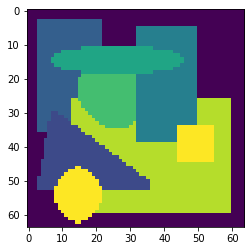

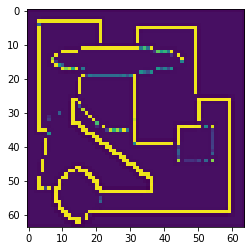

In [15]:
expout = np.load('ExpectedOutput.npy')
expected_output = np.reshape(expout, [1, img.shape[0], img.shape[1], 1])
optimizer = tf.optimizers.Adam(0.1)

for i in range(1000):
    loss = train_step(CNN_sim, optimizer, expected_output, x0, U, A, B, Z, IterNum, h)
    if i % 100 == 0:
        print(loss)

out = CNN_sim(x0, U, A, B, Z, IterNum, h)
print(out.shape)
outimg = out[0, :, :, 0]
plt.imshow(img)  # displaying the input image
plt.figure()
plt.imshow(outimg)

In [16]:
print(A)
print(B)
print(Z)

<tf.Variable 'Variable:0' shape=(3, 3, 1, 1) dtype=float32, numpy=
array([[[[ 0.11267232]],

        [[-0.07950623]],

        [[-0.5161604 ]]],


       [[[-0.13103296]],

        [[ 0.87380594]],

        [[-0.3530841 ]]],


       [[[-0.46337482]],

        [[-0.20419587]],

        [[ 0.20725326]]]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(3, 3, 1, 1) dtype=float32, numpy=
array([[[[-1.615004  ]],

        [[-0.59753495]],

        [[-1.4708594 ]]],


       [[[-0.2992785 ]],

        [[ 5.8627334 ]],

        [[ 0.5454495 ]]],


       [[[-1.0767465 ]],

        [[ 0.05169371]],

        [[-1.5040678 ]]]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-1.9238892], dtype=float32)>
